In [1]:
# !pip install scipy
# !pip install ruptures

# imports

In [1]:
import pandas as pd
from scipy.io import arff
import matplotlib.pyplot as plt
import numpy as np
import ruptures as rpt


# Fluss implementation

In [125]:
import pandas as pd
import numpy as np
import stumpy
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, FancyArrowPatch
from matplotlib import animation
from IPython.display import HTML
from stumpy.floss import _cac
from scipy.signal import argrelextrema


def get_indices_matricies(data,m):
    mp = stumpy.stump(data, m)
    return mp[:, 1] 
        
def get_cac_curves(mpi,L,exclusion_factor):
    cac = _cac(mpi, L=L, excl_factor=exclusion_factor)
    return cac

class Fluss:
    def __init__(self,L,exclusion_factor):
        self.L=L
        self.exclusion_factor = exclusion_factor
        self.custom_extraction_zone = 5*L 
        self.last_regimes = None
        self.last_cac = None
        self.last_data = None
        
    def set_custom_regime_extraction(self, extraction_zone ):
        self.custom_extraction_zone = extraction_zone 
        
    def predict_regimes(self,data):
        self.last_data = data
        mp = stumpy.stump(data, m=self.L)
        cac = _cac(mp[:, 1], L=self.L, excl_factor=self.exclusion_factor)
        self.last_cac = cac

        local_minima_indices = argrelextrema(cac, np.less, order=self.custom_extraction_zone)[0]
        self.last_regimes = local_minima_indices
        return cac, local_minima_indices

    
    def m_predict_regimes(self,data):
        self.last_data = data
        m_mp = np.apply_along_axis(get_indices_matricies, 0, data,self.L)
        m_cac = np.apply_along_axis(get_cac_curves, 0, m_mp,self.L,self.exclusion_factor)
        mean_cac = np.mean(m_cac, axis=1)

        self.last_cac = mean_cac
        
        local_minima_indices = argrelextrema(mean_cac, np.less, order=self.custom_extraction_zone)[0]
        self.last_regimes = local_minima_indices
        return mean_cac, local_minima_indices

            
    def print_latest_output(self, original_points = None):
        fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0})
        axs[0].plot(range(self.last_data.shape[0]), self.last_data)
        axs[1].plot(range(self.last_cac.shape[0]), self.last_cac, color='C1')
        
        for i in self.last_regimes:
            axs[0].axvline(x=i, linestyle="dashed")
            axs[1].axvline(x=i, linestyle="dashed")

        if original_points is not None:            
            for i in original_points:
                axs[0].axvline(x=i, linestyle="dashed", color='g')
                axs[1].axvline(x=i, linestyle="dashed", color='g')
            
        plt.show()

        
def get_evaluation(result, original_points, n):
    prediction_margin =( n/len(original_points)/8)
    print(prediction_margin)
    TP,TN,FP,FN = calculate_TP_TN_FP_FN(n,result,original_points,prediction_margin)
    ASC = calculateASC(n,result,original_points,prediction_margin)
    ASD = calculateASD(n,result,original_points,prediction_margin)
    ADT = calculateADT(n,result,original_points,prediction_margin)
        
    Acc, Prec, Recall, F1 = calculate_ACC_PRE_REC_F1(TP,TN,FP,FN)
    #score = ScoreRegimes(result,original_points,n)
        
        # Dane
    etykiety = ["Acc", "Prec", "Recall", "F1","ASC","ASD","ADT"]
    wartosci = [Acc, Prec, Recall, F1 , ASC , ASD, ADT]
        
        # Tworzenie DataFrame
    evaluation = pd.DataFrame({
            "Metryka": etykiety,
            "Wartość": wartosci
        })
    return evaluation
#eval = get_evaluation(regimes,ch,129276)

def ScoreRegimes(locRegimes, gtRegimes, ts_length):
    """
    Function to score the difference between extracted regimes and ground truth regimes.

    Parameters:
    locRegimes (list or np.array): extracted regimes
    gtRegimes (list or np.array): ground truth regimes
    ts_length (int): length of the time series

    Returns:
    float: score in the range [0, 1], with 0 being the best score
    """
    sumDiff = 0
    numRegimes = len(gtRegimes)

    for i in range(numRegimes):
        # Find the gtRegimes[j] closest to locRegimes[i]
        closest_diff = min(abs(locRegime - gtRegimes[j]) for j, locRegime in enumerate(locRegimes))
        sumDiff += closest_diff

    score = sumDiff / ts_length
    return score

#eval
            

# FlussRegimeSegmentator = Fluss(1000,3,5)
# FlussRegimeSegmentator.turn_custom_regime_extraction()
# # cac , regimes = FlussRegimeSegmentator.predict_regimes(data)
# # FlussRegimeSegmentator.print_latest_output()

# m_data = cricet_stacked_ndarray.astype(np.float64)
# cac , m_cac ,regimes = FlussRegimeSegmentator.m_predict_regimes(m_data)
# FlussRegimeSegmentator.print_latest_output()


# Dataset loading

In [3]:
filepath = './datasets/basic_motions/BasicMotions_TRAIN.arff'

def load_dataset_to_dataframe(path):
    """Load data that is stored within the path

    Args:
        path: string with path containing data
    Returns:
        A pandas dataframe with only data inside
    """
    dataset = arff.loadarff(path)
    df = pd.DataFrame(dataset[0])
    return df 

df = load_dataset_to_dataframe(filepath)


# Clear segementation off dataset 

In [4]:
def stack_time_series(df):
    """This function creates new dataframe without segmentation and classification

    Args:
        df: segmented dataframe
    Returns:
        A pandas dataframe with shape [dimensions of input data,original count of time series]
    """
    dimensionality = df.iloc[0,0].shape[0] if type(df.iloc[0,0][0]) == np.void else 1  # assumption that data dimensionality is the number of rows of first element in dataframe
    # also the first column is expected to store data (second stores classification)
    chunk_size = len(df.iloc[0,0][0])
    # creating new data frame 
    stacked = pd.DataFrame(index=np.arange(dimensionality), columns=np.arange(1))
    
    # filling it with empty numpy arrays
    for i in range(dimensionality):
        stacked.iloc[i, 0] = np.array([])
    # filling the dataframe with data    
    for index, row in df.iterrows():
        i = 0
        if type(row[0][0]) == np.void:
            for r in row[0]:
                #print((type(r))==np.void)
                stacked.iloc[i,0] = np.concatenate((stacked.iloc[i,0],np.array(r.tolist())))
                i += 1
        else:
             stacked.iloc[0,0] = np.concatenate((stacked.iloc[i,0],row[0]))
    return stacked


def dataframe_to_ndarray(df):
    """This function creates ndarray(2 dmiensional, shape: length x dim) of dataframe (shape: dim x length)

    Args:
        df: dataframe
    Returns:
        A numpy array with shape: length x dim)
    """
    ndarray = np.array([])
    for index, row in df.iterrows():
        if index == 0:
            ndarray = row[0]
        else:
            ndarray = np.vstack((ndarray,row[0]))
    return ndarray.transpose()



# Evaluation 

In [5]:
# https://ceur-ws.org/Vol-1226/paper31.pdf

def points_labels_vector(n,change_points):
    """This function creates vector of predicated labels [0,0, ...,1,...0] 
    where 1 means time series at this index is change point, and 0 that there is no change point

    Args:
        n: count of time series
        change_points: 1-D numpy array with change point indexes
    Returns:
        A 1-D numpy array with lenght of n, containing ones and zeros
    """
    predicted_labels = np.zeros(n)
    predicted_labels[change_points] = 1
    return predicted_labels


def calculate_TP_TN_FP_FN(n, predicted_points, original_points, treshold):
    """This function calculates TP, TN, FP, FN , the change point is correct if its distance from original
    change point is closer then treshold, when there is more than one change point within the threshold the additional
    ones are considered FP

    Args:
        n: count of time series
        predicted_points: 1-D numpy array with predicted change point indexes
        original_points: 1-D numpy array with original change point indexes
        treshold: arbitray distance from orignal point
    Returns:
        A scalar values of TP, TN, FP, FN
    """
    predicted_labels = points_labels_vector(n, predicted_points)
    original_labels = points_labels_vector(n, original_points)

    TP = 0
    TN = 0
    FP = 0
    FN = 0
    zone_counter = np.zeros(len(original_points), dtype=bool)
    for index, value in enumerate(predicted_labels):
        if(np.min(np.abs(original_points - index)) < treshold):
            if value == 1:
                which_point = np.argmin(np.abs(original_points - index))
                #print(original_points)
                #print(which_point)
                if zone_counter[which_point] == True :
                    FP+=1
                else:
                    TP+=1     
                    zone_counter[which_point] = True
        else:
            if value == 0:
                TN+=1
            else:
                FP+=1

    for index , val in enumerate(zone_counter):
         if val == False:
             FN+=1

    return TP, TN, FP, FN
            


def calculate_ACC_PRE_REC_F1(TP,TN,FP,FN):
    A = (TP+TN)/(TP+TN+FP+FN)
    P = TP/(TP+FP)
    R = TP/(TP+FN)
    F1 = (2*TP)/(2*TP+FN+FP)
    return A,P,R,F1


def calculateASC(n, predicted_points, original_points, treshold):
    """This function calculates average count of predicted change points in segmentation zone

    Args:
        n: count of time series
        predicted_points: 1-D numpy array with predicted change point indexes
        original_points: 1-D numpy array with original change point indexes
        treshold: arbitray distance from orignal point
    Returns:
        average change point count for segmentation zone 
    """
    predicted_labels = points_labels_vector(n, predicted_points)
    original_labels = points_labels_vector(n, original_points)

    sum = 0
    zone_counter = np.zeros(len(predicted_points), dtype=bool)
    for index, value in enumerate(predicted_labels):
        if(np.min(np.abs(original_points - index)) < treshold):
            if value == 1:
                sum+=1
 
    return sum/len(original_points)

def calculateASD(n, predicted_points, original_points, treshold):
    """This function calculates average distance of predicted change points from the center of segmentation zone

    Args:
        n: count of time series
        predicted_points: 1-D numpy array with predicted change point indexes
        original_points: 1-D numpy array with original change point indexes
        treshold: arbitray distance from orignal point
    Returns:
        average distance 
    """
    predicted_labels = points_labels_vector(n, predicted_points)
    original_labels = points_labels_vector(n, original_points)

    ASD = 0
    div = 0
    zone_counter = np.zeros(len(predicted_points), dtype=bool)
    for index, value in enumerate(predicted_labels):
        if(np.min(np.abs(original_points - index)) < treshold):
            if value == 1:
                ASD += np.min(np.abs(original_points - index))
                div += 1
 
    return (ASD/div) if div > 0 else -1


def calculateADT(n, predicted_points, original_points, treshold):
    """This function calculates average direction tendency, above 0.5 means that algorithm tends to place change points after
        segmentation zone center. Value below 0.5 means the tendency is to put change points before segmentation zone center
    Args:
        n: count of time series
        predicted_points: 1-D numpy array with predicted change point indexes
        original_points: 1-D numpy array with original change point indexes
        treshold: arbitray distance from orignal point
    Returns:
        average direction tendency
    """
    predicted_labels = points_labels_vector(n, predicted_points)
    original_labels = points_labels_vector(n, original_points)

    PostSeg = 0
    PreSeg = 0
    zone_counter = np.zeros(len(predicted_points), dtype=bool)
    for index, value in enumerate(predicted_labels):
        if(np.min(np.abs(original_points - index)) < treshold):
            if value == 1:
                arg = np.argmin(np.abs(original_points - index))
                if index > original_points[arg]:
                    PostSeg += 1
                else:
                    PreSeg += 1
 
    return (PostSeg/(PostSeg+PreSeg)) if (PostSeg+PreSeg) > 0 else -1



# Classic Change points Algorithms

In [103]:
def predict_change_points_bottomup(data, n, original_points, cost_function):
    algo = rpt.BottomUp(model=cost_function)
    algo.fit(data)
    result = algo.predict(n_bkps = len(original_points))
    evaluation = get_evaluation(result[:-1], original_points, n)
    rpt.display(data, np.append(original_points,result[-1]), result)
    return evaluation, result[:-1]


def predict_change_points_binseg(data, n, original_points, cost_function):
    algo = rpt.Binseg(model = cost_function)
    algo.fit(data)
    result = algo.predict(n_bkps = len(original_points))

    evaluation = get_evaluation(result[:-1], original_points, n )
    rpt.display(data, np.append(original_points,result[-1]), result)
    return evaluation, result[:-1]

def predict_change_points_window(data, n, original_points, cost_function, window_size):
    algo = None
    if type(cost_function) == str:
        algo = rpt.Window(width = window_size, model = cost_function)
    else:
        algo = rpt.Window(width = window_size, custom_cost = cost_function)

    algo.fit(data)
    result = algo.predict(n_bkps = len(original_points))
    evaluation = get_evaluation(result[:-1], original_points, n)

    rpt.display(data, np.append(original_points,result[-1]), result)
    return evaluation, result[:-1]

# Benchmark Class

In [8]:
class SegmenationAlgorithmsBenchmark():
    def __init__(self, experiments_number, algorithms_number, algorithms_tags):
        self.experiments_number = experiments_number
        self.algorithms_number = algorithms_number
        self.ranksSum = np.zeros(algorithms_number)
        self.experiments_conducted = 0 
        self.algorithms_tags = algorithms_tags

    def add_experiment(self, results):
        if self.experiments_conducted == self.experiments_number:
            raise ValueError("Niewłaściwa wartość")
        self.experiments_conducted += 1
        sorted_indices = np.argsort(results)[::-1] + 1
        self.ranksSum += sorted_indices
        if self.experiments_conducted == self.experiments_number:
            self.print_current_results()
            
    def print_current_results(self):
        print("Conducted experimets: "+str(self.experiments_conducted))
        for i in range(self.algorithms_number):
            print(self.algorithms_tags[i]+" current average rank is: "+str((float(self.ranksSum[i])/ self.experiments_conducted)))
                    
# arr = np.array([3,4,16])
# print(np.argsort(arr[::-1]))

        
        

# Randomize dataframe rows

In [7]:
def stack_time_series_randomly(df,opt):
    """This function creates new dataframe without segmentation and classification, what is more its rows are randomly shuffled

    Args:
        df: segmented dataframe
        seed: this value is being passed to the sample function which shuffles rows in dataframe
    Returns:
        A pandas dataframe with shape [dimensions of input data,original count of time series]
        , numpy array containing change points
    """
    print( df.iloc[0,0].shape)
    dimensionality = df.iloc[0,0].shape[0] if type(df.iloc[0,0][0]) == np.void else 1  # assumption that data dimensionality is the number of rows of first element in dataframe
    
    change_points = np.array([],dtype=int)
    chunk_size = len(df.iloc[0,0][0])

    # creating new data frame 
    stacked = pd.DataFrame(index=np.arange(dimensionality), columns=np.arange(1))

    # randomize rows
    if(opt == True):
        df = df.sample(frac=1, random_state=43).reset_index(drop=True)
    # filling it with empty numpy arrays
    print(dimensionality)
    for i in range(dimensionality):
        stacked.iloc[i, 0] = np.array([])

    last_class = df.iloc[0,1]
    # filling the dataframe with data    
    for index, row in df.iterrows():
        i = 0
        if last_class != row[1]:
            change_points = np.append(change_points,int(index*chunk_size))
        last_class = row[1]
        if type(row[0][0]) == np.void:
            for r in row[0]:
                #print((type(r))==np.void)
                stacked.iloc[i,0] = np.concatenate((stacked.iloc[i,0],np.array(r.tolist())))
                i += 1
        else:
             stacked.iloc[0,0] = np.concatenate((stacked.iloc[i,0],row[0]))
    return stacked, change_points

# random_stacked, change_points = stack_time_series_randomly(df,True)
# random_stacked = dataframe_to_ndarray(random_stacked)

# plt.plot(random_stacked)
# plt.show()
# shuffled_df = df.sample(frac=1, random_state=42).reset_index(drop=True)
# print("\nPomieszany DataFrame:")
#print(random_stacked)

# Benchmark Beginning

In [ ]:
Benchmark = SegmenationAlgorithmsBenchmark(10, 2, ["bottomup","fluss"])

# Load 10 datasets

# PenDigits

In [ ]:
filepath = './datasets/pen_digits/PenDigits_TRAIN.arff'

df = load_dataset_to_dataframe(filepath)
# print((df.iloc[1,0]))
# # print(len(df.iloc[1,0][0]))
# print((df.iloc[1,1]))
# print(df.shape)
pen_stacked , ch = stack_time_series(df,43,8)
pen_stacked_ndarray = dataframe_to_ndarray(pen_stacked)
# print(pen_stacked.shape)
# print(pen_stacked_ndarray)

#plt.plot(pen_stacked_ndarray[0:150])
# data = pen_stacked_ndarray[8:16]
# x = pen_stacked_ndarray[:, 0]
# y = pen_stacked_ndarray[:, 1]
# print(data)
# # Tworzenie wykresu
# plt.figure(figsize=(10, 6))  # Opcjonalnie, ustawienie rozmiaru wykresu
# plt.scatter(x, y, s=10)  # s=10 ustawia rozmiar punktów
# plt.xlabel('X axis')
# plt.ylabel('Y axis')
# plt.title('Scatter Plot of Points')
# plt.grid(True)
# plt.show()

algo = rpt.BottomUp(model="normal")
algo.fit(pen_stacked_ndarray)
result = algo.predict(n_bkps = len(ch))
# plt.plot(random_stacked)
# print(result)
n = len(pen_stacked_ndarray)
change_points = ch
TP,TN,FP,FN = calculate_TP_TN_FP_FN(n,result[:-1],change_points,50)
ASC = calculateASC(n,result[:-1],change_points,50)
ASD = calculateASD(n,result[:-1],change_points,50)
ADT = calculateADT(n,result[:-1],change_points,50)


Acc, Prec, Recall, F1 = calculate_ACC_PRE_REC_F1(TP,TN,FP,FN)


# Dane
etykiety = ["Acc", "Prec", "Recall", "F1","ASC","ASD","ADT"]
wartosci = [Acc, Prec, Recall, F1 , ASC , ASD, ADT]

# Tworzenie DataFrame
evaluation = pd.DataFrame({
    "Metryka": etykiety,
    "Wartość": wartosci
})
#help(rpt.BottomUp)

rpt.display(pen_stacked_ndarray, ch,result)



# HeartBeat

In [9]:
filepath = './datasets/heart_beat/HeartBeat_TRAIN.arff'

df = load_dataset_to_dataframe(filepath)
# print((df.iloc[1,0]))
# # print(len(df.iloc[1,0][0]))
# print((df.iloc[1,1]))

# pen_stacked , ch = stack_time_series(df,43,8)
# pen_stacked_ndarray = dataframe_to_ndarray(pen_stacked)

In [11]:

print((df))
print((df.iloc[0,1]))
print((df.iloc[0,0].shape))
print(len(df.iloc[0,0][0]))
heart_stacked , ch = stack_time_series_randomly(df,False)
heart_stacked_ndarray = dataframe_to_ndarray(heart_stacked)

#print(df.iloc[0,0][0])
print(heart_stacked_ndarray)
print(heart_stacked_ndarray.shape)

print(type(df.iloc[0,0][0]) == np.void)

                                             Heartbeat       target
0    [[0.000949, 0.001488, 0.000314, 0.000995, 0.00...    b'normal'
1    [[0.020264, 0.017023, 0.006052, 0.00395, 0.023...    b'normal'
2    [[0.021082, 0.020687, 0.009948, 0.002039, 0.00...    b'normal'
3    [[0.001634, 0.002511, 0.003524, 0.006575, 0.00...    b'normal'
4    [[0.020809, 0.007473, 0.012304, 0.01134, 0.012...    b'normal'
..                                                 ...          ...
199  [[0.002383, 0.003405, 0.004029, 0.0046, 0.0039...  b'abnormal'
200  [[0.002211, 0.001956, 0.002747, 0.000866, 0.00...  b'abnormal'
201  [[0.009989, 0.002671, 0.001707, 0.001381, 0.00...  b'abnormal'
202  [[0.000815, 0.001325, 0.00128, 0.001586, 0.001...  b'abnormal'
203  [[0.002995, 0.003105, 0.00304, 0.00068, 0.0044...  b'abnormal'

[204 rows x 2 columns]
b'normal'
(61,)
405
(61,)
61
[[0.000949 0.001288 0.000529 ... 0.078312 0.045608 0.12107 ]
 [0.001488 0.00114  0.001635 ... 0.14568  0.1198   0.13385 ]
 [0.00031

[23085]


(<Figure size 720x144 with 1 Axes>, [<Axes: >])

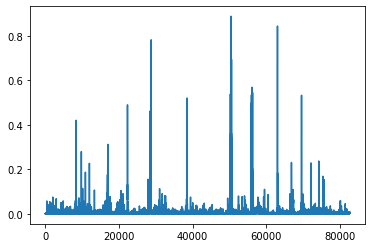

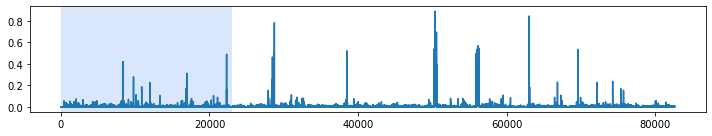

In [12]:
plt.plot(heart_stacked_ndarray[:,0])
print(ch)
rpt.display(heart_stacked_ndarray[:,0], ch)

In [ ]:
data = heart_stacked_ndarray[:,0]
algo = rpt.BottomUp(model="l1")
algo.fit(data)
result = algo.predict(n_bkps = len(ch))
# plt.plot(random_stacked)
# print(result)
n = 82620
change_points = ch
TP,TN,FP,FN = calculate_TP_TN_FP_FN(n,result[:-1],change_points,50)
ASC = calculateASC(n,result[:-1],change_points,50)
ASD = calculateASD(n,result[:-1],change_points,50)
ADT = calculateADT(n,result[:-1],change_points,50)


Acc, Prec, Recall, F1 = calculate_ACC_PRE_REC_F1(TP,TN,FP,FN)


# Dane
etykiety = ["Acc", "Prec", "Recall", "F1","ASC","ASD","ADT"]
wartosci = [Acc, Prec, Recall, F1 , ASC , ASD, ADT]

# Tworzenie DataFrame
evaluation = pd.DataFrame({
    "Metryka": etykiety,
    "Wartość": wartosci
})
#help(rpt.BottomUp)

rpt.display(heart_stacked_ndarray[:,0], ch,result)
evaluation

# Wine

1.781622
        att1      att2      att3      att4      att5      att6      att7  \
0   1.781622  1.641665  1.513937  1.394362  1.282035  1.174689  1.070514   
1   1.779750  1.638856  1.512006  1.391952  1.277787  1.170418  1.066673   
2   1.776492  1.636260  1.508282  1.388472  1.275469  1.166551  1.063533   
3   1.774080  1.635140  1.507890  1.388734  1.277222  1.171555  1.066788   
4   1.776502  1.637654  1.510938  1.392310  1.279075  1.172580  1.069230   
5   1.776937  1.636610  1.510630  1.392272  1.280190  1.173488  1.070821   
6   1.658420  1.523814  1.403071  1.293060  1.189757  1.090927  0.994779   
7   1.656518  1.524463  1.404942  1.293927  1.189626  1.089801  0.993557   
8   1.660256  1.527434  1.406240  1.293990  1.190237  1.091403  0.995700   
9   1.716077  1.579077  1.455553  1.340114  1.232311  1.129000  1.030181   
10  1.717974  1.578722  1.454293  1.339297  1.231938  1.129071  1.028450   
11  1.715088  1.579515  1.455614  1.339345  1.230708  1.127906  1.029594   
12 

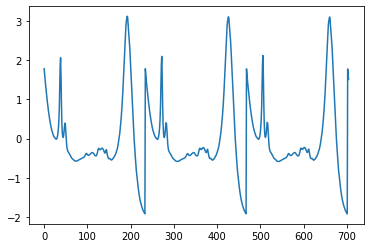

[ 1.781622   1.641665   1.5139373 ... -1.8674339 -1.8885755 -1.9056687]


(<Figure size 720x144 with 1 Axes>, [<Axes: >])

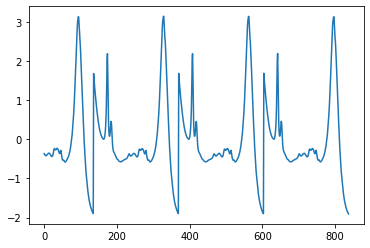

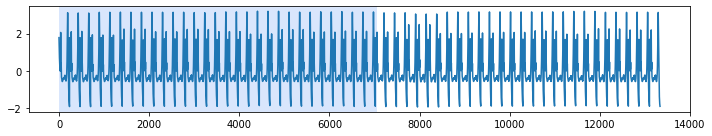

In [40]:
filepath = './datasets/Wine/Wine_TRAIN.arff'

df = load_dataset_to_dataframe(filepath)
print(df.iloc[0,0])
print(df)

# Konwersja dataframe na ndarray
ndarray = df.values
ch = ndarray[:,-1]
ndarray = ndarray[:, :-1]
# Alternatywnie można użyć .to_numpy() w nowszych wersjach Pandas
# ndarray = df.to_numpy()

window_size = 235


change_points = np.array([],dtype=int)
l_p = ch[0]
for i, p in enumerate(ch):
    if(p!=l_p):
        change_points = np.append(change_points,int(i*window_size))
    l_p = p

print(ndarray.flatten())
print(ndarray.flatten().shape)
print(change_points)
print(ch)
plt.plot(ndarray.flatten()[:3*window_size])
plt.show()
plt.plot(ndarray.flatten()[12500:])

wine_ds = ndarray.flatten().astype(dtype = float)

print(wine_ds)
rpt.display(wine_ds,change_points)

1175


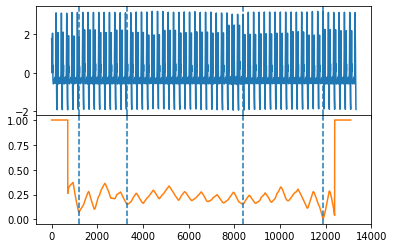

NameError: name 'get_fluss_evaluation' is not defined

In [30]:
FlussRegimeSegmentator = Fluss(window_size,3,1)
FlussRegimeSegmentator.turn_custom_regime_extraction()

cac  ,regimes = FlussRegimeSegmentator.predict_regimes(wine_ds)
FlussRegimeSegmentator.print_latest_output()

eval = get_fluss_evaluation(regimes,original_points,n)
eval

# WalkingSittingStanding

In [41]:
filepath = './datasets/WalkingSittingStanding/WalkingSittingStanding_TEST.ts'

df = load_dataset_to_dataframe(filepath)

print(len(df.iloc[0,0][0]))

cricet_stacked,ch  = stack_time_series_randomly(df,False)
cricet_stacked_ndarray = dataframe_to_ndarray(cricet_stacked)

# #print(df.iloc[0,0][0])
# print(heart_stacked_ndarray)
print(cricet_stacked_ndarray.shape)
plt.plot(cricet_stacked_ndarray[:,0])
# print(type(df.iloc[0,0][0]) == np.void)
rpt.display(cricet_stacked_ndarray, ch)

ParseArffError: Error while parsing header, error was: Error parsing line @problemName test.ts


# Experiment 1 (RacketSports)

In [174]:
filepath = './datasets/RacketSports/RacketSports_TRAIN.arff'

df = load_dataset_to_dataframe(filepath)
window_size = len(df.iloc[0,0][0])

racket_ds, change_points = stack_time_series_randomly(df,False)
racket_ds = dataframe_to_ndarray(racket_ds)
n = racket_ds.shape[0]

(6,)
6


<class 'str'>
188.75
[1650, 3360, 3705]


,Metryka,Wartość
0,Acc,0.998824
1,Prec,0.333333
2,Recall,0.333333
3,F1,0.333333
4,ASC,0.333333
5,ASD,150.000000
6,ADT,0.000000


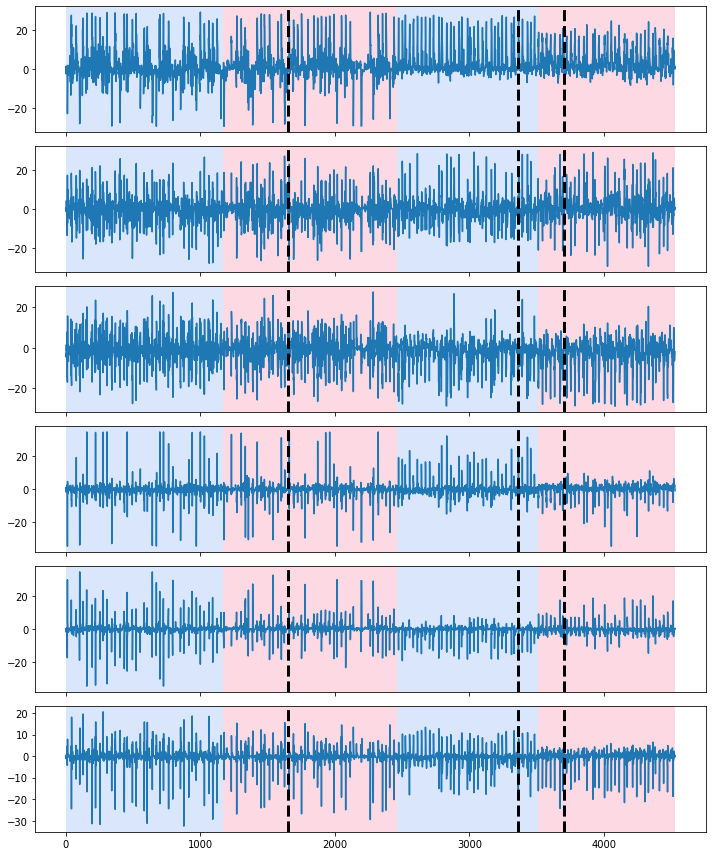

In [99]:
eval, result = predict_change_points_window(racket_ds, n, change_points, "rbf", window_size)
print(result)
eval


188.75
[2470, 3535, 3555]


,Metryka,Wartość
0,Acc,0.999412
1,Prec,0.666667
2,Recall,0.666667
3,F1,0.666667
4,ASC,1.000000
5,ASD,26.666667
6,ADT,1.000000


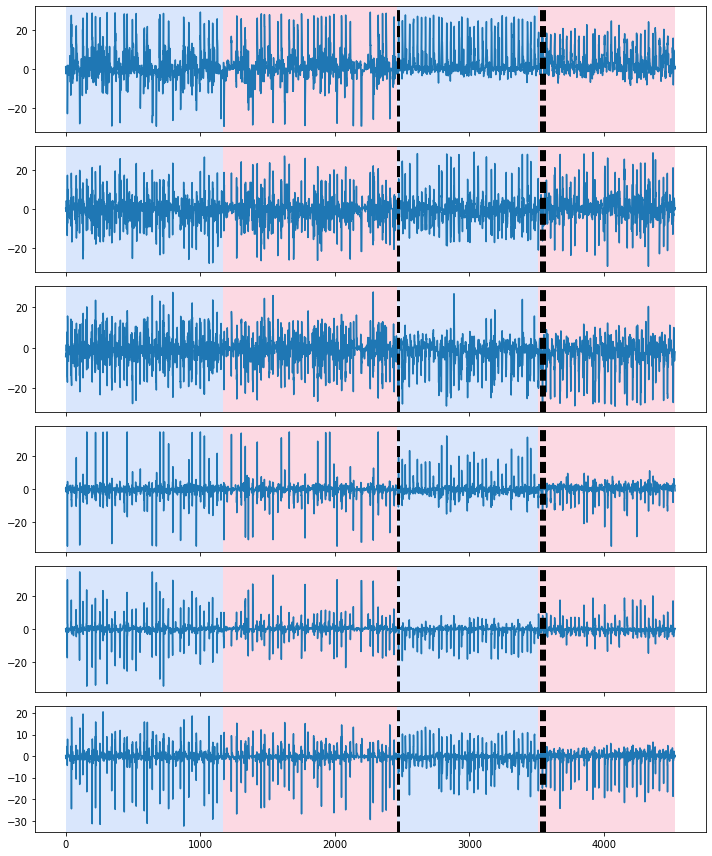

In [106]:
eval, result = predict_change_points_binseg(racket_ds, n, change_points, "l1")
print(result)
eval


188.75
[1170 2460 3510]
[1360, 2440, 3490]


,Metryka,Wartość
0,Acc,0.999412
1,Prec,0.666667
2,Recall,0.666667
3,F1,0.666667
4,ASC,0.666667
5,ASD,20.000000
6,ADT,0.000000


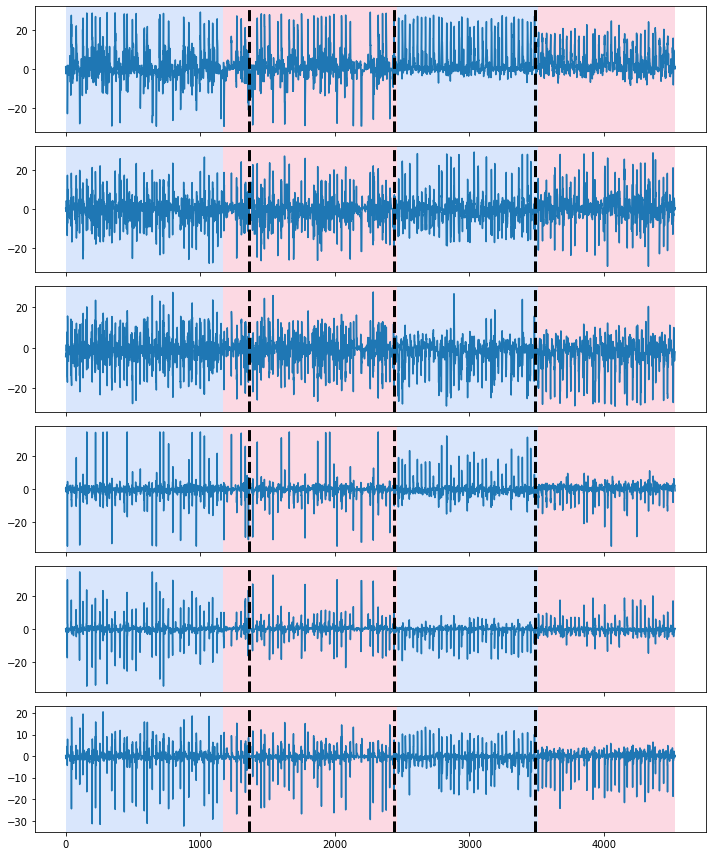

In [176]:
eval, result = predict_change_points_bottomup(racket_ds, n, change_points, "linear")
print(change_points)
print(result)
eval


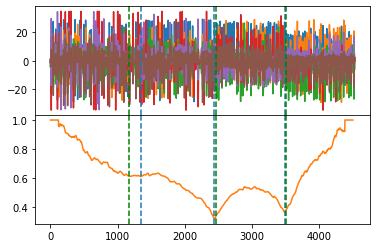

188.75
[1343 2440 3484]


,Metryka,Wartość
0,Acc,1.000000
1,Prec,1.000000
2,Recall,1.000000
3,F1,1.000000
4,ASC,1.000000
5,ASD,73.000000
6,ADT,0.333333


In [126]:
FlussRegimeSegmentator = Fluss(window_size, 4)

cac, regimes = FlussRegimeSegmentator.m_predict_regimes(racket_ds)
FlussRegimeSegmentator.print_latest_output(change_points)

eval = get_evaluation(regimes,change_points,racket_ds.shape[0])

#rpt.display(racket_ds,change_points,regimes)
print(regimes)
eval

# Experiment 2 (Earthquakes)

         att1      att2      att3      att4      att5      att6      att7  \
0   -0.518009 -0.518009  2.654211 -0.518009 -0.518009 -0.518009 -0.518009   
1    1.943733 -0.353115 -0.353115 -0.353115 -0.353115 -0.353115 -0.353115   
2    2.638517 -0.316102 -0.316102 -0.316102 -0.316102 -0.316102 -0.316102   
3   -0.531138 -0.531138 -0.531138 -0.531138 -0.531138 -0.531138 -0.531138   
4   -0.593665  2.020105  1.174727 -0.593665 -0.593665  1.606043  1.217859   
..        ...       ...       ...       ...       ...       ...       ...   
317 -0.579610 -0.579610 -0.579610 -0.579610  1.584470  1.892368 -0.579610   
318 -0.478984 -0.478984  1.665022 -0.478984 -0.478984 -0.478984 -0.478984   
319 -0.264652 -0.264652 -0.264652 -0.264652 -0.264652 -0.264652 -0.264652   
320 -0.490827 -0.490827 -0.490827 -0.490827 -0.490827 -0.490827 -0.490827   
321 -0.483922 -0.483922 -0.483922  1.632621  1.651519 -0.483922 -0.483922   

         att8      att9     att10  ...    att504    att505    att506  \
0  

(<Figure size 720x144 with 1 Axes>, [<Axes: >])

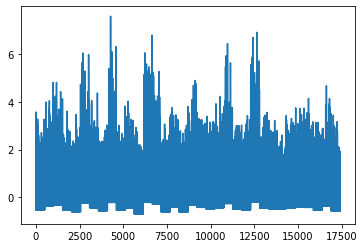

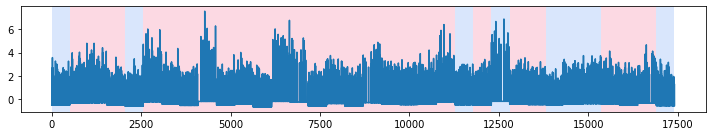

In [182]:
filepath = './datasets/Earthquakes/Earthquakes_TRAIN.arff'

df = load_dataset_to_dataframe(filepath)
print(df)

window_size = 512
# Konwersja dataframe na ndarray
ndarray = df.values
ch = ndarray[:,-1]
ndarray = ndarray[:, :-1]
# Alternatywnie można użyć .to_numpy() w nowszych wersjach Pandas
# ndarray = df.to_numpy()

change_points = np.array([],dtype=int)
l_p = ch[0]
for i, p in enumerate(ch):
    if(p!=l_p):
        change_points = np.append(change_points,int(i*512))
    l_p = p

earth_ds = ndarray.flatten().astype(dtype = float)

x = 10
i = change_points[x]
plt.plot(earth_ds[:i])
rpt.display(earth_ds[:i], change_points[:(x+1)])
# result,eval =  predict_change_points(ndarray.flatten(),len(ndarray.flatten()),change_points)
# rpt.display(ndarray.flatten(), change_points,result)
# eval

217.6
[1795, 7845, 8915, 13185, 13445, 14290, 15670, 16010, 16760, 17050]


,Metryka,Wartość
0,Acc,0.998623
1,Prec,0.100000
2,Recall,0.100000
3,F1,0.100000
4,ASC,0.200000
5,ASD,145.000000
6,ADT,0.500000


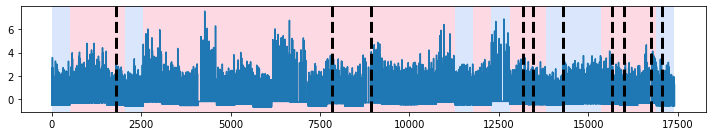

In [168]:
eval, result = predict_change_points_window(earth_ds[:i], earth_ds[:i].shape[0], change_points[:x],"l2" , window_size)
print(result)
eval


725.3333333333334
[510, 9230, 16900]


,Metryka,Wartość
0,Acc,0.999706
1,Prec,0.333333
2,Recall,0.333333
3,F1,0.333333
4,ASC,0.333333
5,ASD,660.000000
6,ADT,0.000000


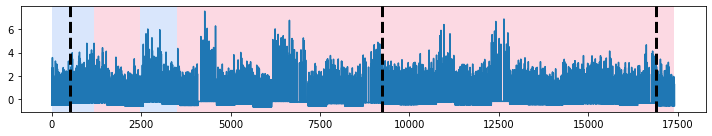

In [177]:
eval, result = predict_change_points_binseg(earth_ds[:i], earth_ds[:i].shape[0], change_points[:x],"l1" )
print(result)
eval


217.6
[1860, 2535, 5800, 6140, 7170, 8680, 12275, 12810, 14295, 14335]


,Metryka,Wartość
0,Acc,0.999082
1,Prec,0.400000
2,Recall,0.400000
3,F1,0.400000
4,ASC,0.400000
5,ASD,59.000000
6,ADT,0.250000


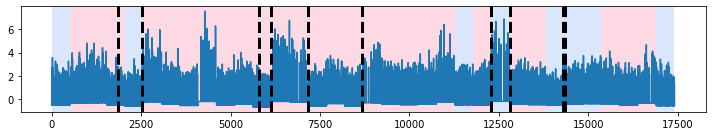

In [187]:
eval, result = predict_change_points_bottomup(earth_ds[:i], earth_ds[:i].shape[0], change_points[:x],"cosine" )
print(result)
eval


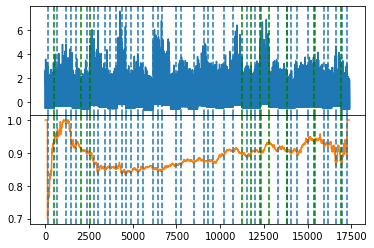

217.6


,Metryka,Wartość
0,Acc,0.997169
1,Prec,0.170732
2,Recall,0.700000
3,F1,0.274510
4,ASC,0.700000
5,ASD,93.142857
6,ADT,0.714286


In [154]:
FlussEarth = Fluss(50, 1)

cac, regimes = FlussRegimeSegmentator.predict_regimes(earth_ds[:i])
FlussRegimeSegmentator.print_latest_output(change_points[:x])

eval = get_evaluation(regimes, change_points[:x], earth_ds[:i].shape[0])

eval

# Experiment 6 (UMD)

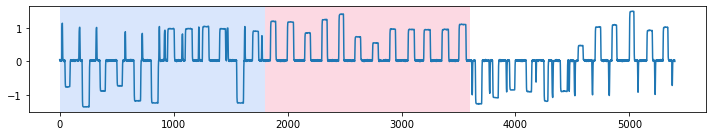

In [251]:
filepath = './datasets/UMD/UMD_TRAIN.arff'
def load_data_1d_stacked(filepath):
    df = load_dataset_to_dataframe(filepath)
    # mask = df['target'].values == b'4'
    # mask1 = df['target'].values == b'11'
    # ndarray = df.values[mask]
    # ndarray1 = df.values[mask1]
    # sw_leaf_data = np.concatenate((ndarray[:,:-1].flatten()[:1500], ndarray1[:,:-1].flatten()[:1500])).astype(dtype=float)
    original_points = np.array([])
    data = np.array([])
    groups = df.groupby('target')
    window_size = len(df.columns) - 1
    # Iteracja po grupach
    sum = 0 
    for name, group in groups:
        #print(f"Grupa: {name}")
        #print(group.shape[0])
        #print(group)
        data = np.concatenate((data, group.values[:,:-1].flatten())).astype(dtype=float)
        original_points = np.append(original_points, sum + group.shape[0]*( group.shape[1]-1))
        sum += group.shape[0]*( group.shape[1]-1)
    return data, original_points[:-1].astype(dtype = int), window_size
    

umd_data, original_points, window_size = loadSweadishLeafsWithRegimes(filepath)

rpt.display(umd_data, original_points)
n = umd_data.shape[0]

C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


337.5
[2065, 3500]


,Metryka,Wartość
0,Acc,1.0
1,Prec,1.0
2,Recall,1.0
3,F1,1.0
4,ASC,1.0
5,ASD,182.5
6,ADT,0.5


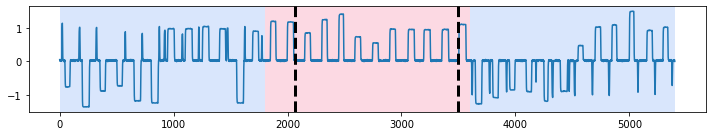

In [259]:
eval, result = predict_change_points_window(umd_data, n, original_points, "normal", window_size)
print(result)
eval


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


337.5
[870, 3570]


,Metryka,Wartość
0,Acc,0.999506
1,Prec,0.500000
2,Recall,0.500000
3,F1,0.500000
4,ASC,0.500000
5,ASD,30.000000
6,ADT,0.000000


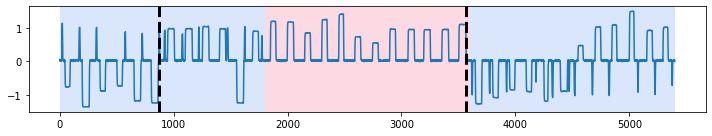

In [258]:
eval, result = predict_change_points_binseg(umd_data, n, original_points, "normal")
print(result)
eval


337.5
[865, 3650]


,Metryka,Wartość
0,Acc,0.999506
1,Prec,0.500000
2,Recall,0.500000
3,F1,0.500000
4,ASC,0.500000
5,ASD,50.000000
6,ADT,1.000000


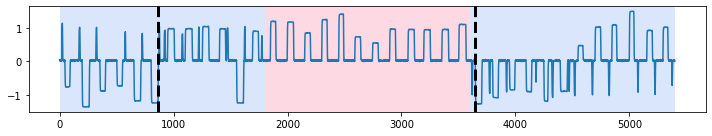

In [262]:
eval, result = predict_change_points_bottomup(umd_data, n, original_points, "l2")
print(result)
eval


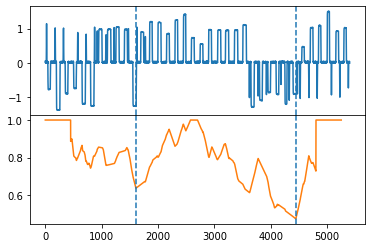

337.5


,Metryka,Wartość
0,Acc,0.999506
1,Prec,0.500000
2,Recall,0.500000
3,F1,0.500000
4,ASC,0.500000
5,ASD,192.000000
6,ADT,0.000000


In [255]:
FlussRegimeSegmentator = Fluss(window_size, 3)

cac, regimes = FlussRegimeSegmentator.predict_regimes(umd_data)
FlussRegimeSegmentator.print_latest_output()

eval = get_evaluation(regimes, original_points, n)
eval

# SwedishLeaf(być może?)

         att1     att2      att3      att4      att5      att6      att7  \
0    1.524750  1.53812  1.410790  1.244400  1.039470  0.868676  0.664257   
1    2.214930  2.05051  1.842350  1.635900  1.432590  1.285370  1.143260   
2    1.872010  1.72637  1.573640  1.396900  1.252210  1.083760  0.955383   
3    1.731019  1.70220  1.553009  1.387209  1.144580  0.951378  0.733035   
4    1.842670  1.74943  1.593560  1.420510  1.268400  1.118720  0.972792   
..        ...      ...       ...       ...       ...       ...       ...   
495  1.555160  1.39118  1.027670  0.747651  0.425793  0.158014  0.152089   
496  1.823961  1.74961  1.579271  1.384801  1.204190  1.022790  0.876355   
497  2.009910  1.89306  1.711190  1.492730  1.312480  1.097560  0.949675   
498  1.474660  1.49555  1.358110  1.142910  0.906578  0.752583  0.985894   
499  2.021830  1.92956  1.740330  1.581830  1.428630  1.250230  1.103560   

         att8      att9     att10  ...    att120    att121    att122  \
0    0.489801  

(<Figure size 720x144 with 1 Axes>, [<Axes: >])

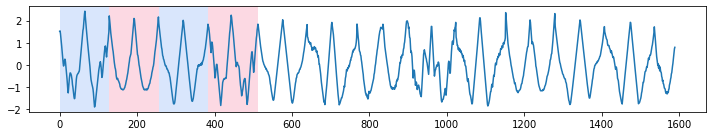

In [16]:
filepath = './datasets/SwedishLeaf/SwedishLeaf_TRAIN.arff'

df = load_dataset_to_dataframe(filepath)
print(df)
print(df.shape)

# Konwersja dataframe na ndarray
ndarray = df.values
ch = ndarray[:,-1]
ndarray = ndarray[:, :-1]
# Alternatywnie można użyć .to_numpy() w nowszych wersjach Pandas
# ndarray = df.to_numpy()

change_points = np.array([],dtype=int)
l_p = ch[0]
for i, p in enumerate(ch):
    if(p!=l_p):
        change_points = np.append(change_points,int(i*128))
    l_p = p

rpt.display(ndarray.flatten()[0:1590], change_points[:4])

# result,eval =  predict_change_points(ndarray.flatten(),len(ndarray.flatten()),change_points)
# rpt.display(ndarray.flatten(), change_points,result)
# eval

# FreezerSmallTrain

In [ ]:
filepath = './datasets/FreezerSmallTrain/FreezerSmallTrain_TRAIN.arff'

df = load_dataset_to_dataframe(filepath)
print(df)
print(df.shape)

# Konwersja dataframe na ndarray
ndarray = df.values
ch = ndarray[:,-1]
ndarray = ndarray[:, :-1]
# Alternatywnie można użyć .to_numpy() w nowszych wersjach Pandas
# ndarray = df.to_numpy()

change_points = np.array([],dtype=int)
l_p = ch[0]
for i, p in enumerate(ch):
    if(p!=l_p):
        change_points = np.append(change_points,int(i*301))
    l_p = p

print(change_points)
rpt.display(ndarray.flatten(), change_points)

result,eval =  predict_change_points(ndarray.flatten(),len(ndarray.flatten()),change_points)
rpt.display(ndarray.flatten(), change_points,result)
eval

# Experiment 3 (Libras)

In [210]:
filepath = './datasets/Libras/Libras_TRAIN.arff'

df = load_dataset_to_dataframe(filepath)

window_size = len(df.iloc[0,0][0])



libras_ds, original_points  = stack_time_series_randomly(df,False)
libras_ds = dataframe_to_ndarray(libras_ds)

n = libras_ds.shape[0]
# rpt.display(libras_ds, original_points)



(2,)
2


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


72.32142857142857


,Metryka,Wartość
0,Acc,0.997042
1,Prec,0.357143
2,Recall,0.357143
3,F1,0.357143
4,ASC,0.428571
5,ASD,22.500000
6,ADT,0.333333


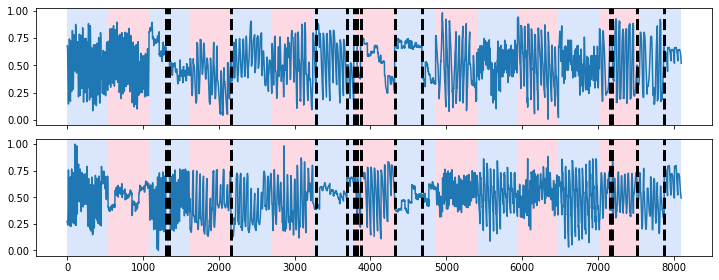

In [218]:
eval, result =  predict_change_points_window(libras_ds,n,original_points,"normal",window_size)
eval

72.32142857142857


,Metryka,Wartość
0,Acc,0.997370
1,Prec,0.428571
2,Recall,0.428571
3,F1,0.428571
4,ASC,0.428571
5,ASD,22.500000
6,ADT,0.500000


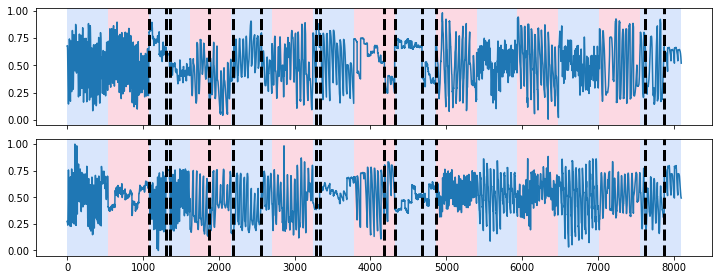

In [220]:
eval, result =  predict_change_points_binseg(libras_ds,n,original_points,"l1")
eval

72.32142857142857


,Metryka,Wartość
0,Acc,0.997042
1,Prec,0.357143
2,Recall,0.357143
3,F1,0.357143
4,ASC,0.428571
5,ASD,11.666667
6,ADT,0.166667


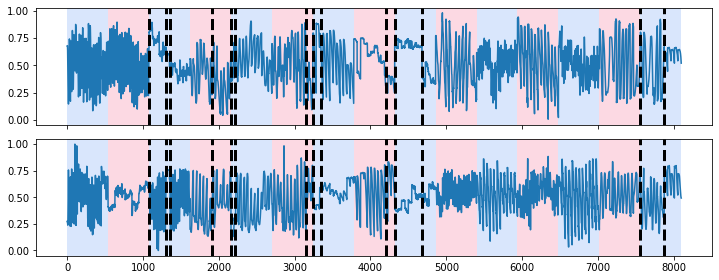

In [214]:
eval, result =  predict_change_points_bottomup(libras_ds,n,original_points,"l2")
eval

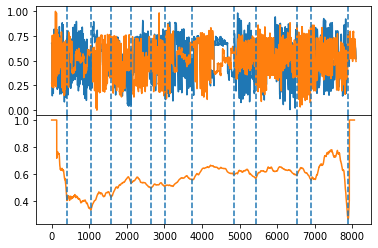

72.32142857142857


,Metryka,Wartość
0,Acc,0.998356
1,Prec,0.666667
2,Recall,0.571429
3,F1,0.615385
4,ASC,0.571429
5,ASD,39.750000
6,ADT,0.250000


In [224]:
FlussRegimeSegmentator = Fluss(window_size,3)

cac, regimes = FlussRegimeSegmentator.m_predict_regimes(libras_ds)
FlussRegimeSegmentator.print_latest_output()

eval = get_evaluation(regimes,original_points,n)
eval

In [58]:
Benchmark.add_experiment([evalbm.iloc[3,1], eval.iloc[3,1]])
Benchmark.print_current_results()

bottomup current average rank is: 2.0
fluss current average rank is: 1.0


# New algorithms

        att1      att2      att3      att4      att5      att6      att7  \
0   0.053053  0.040693  0.039424  0.006439  0.018154  0.043179  0.015576   
1   0.043683  0.044506  0.044794  0.048495  0.020071  0.055454  0.051247   
2   0.022591  0.041485  0.036357  0.041029  0.043406  0.021945  0.006065   
3   0.002490  0.007718  0.029483  0.045494  0.045347  0.005060  0.047209   
4   0.030316  0.003985  0.044046  0.037493  0.006531  0.033350  0.020327   
5   0.010965  0.016505  0.033659  0.012063  0.018570  0.033006  0.038811   
6   0.044371  0.052699  0.012101  0.025012  0.009519  0.054856  0.029893   
7   0.033693  0.004775  0.026586  0.022547  0.043450  0.015039  0.018163   
8  -0.000551  0.034474  0.007377  0.009250  0.001402  0.021975  0.036177   
9   0.009621  0.033562  0.011098  0.014061  0.037549  0.045264  0.016221   
10  0.010965  0.016505  0.033659  0.012063  0.018570  0.033006  0.038811   
11  0.026300  0.020641  0.042976  0.030474  0.028347  0.026438  0.043636   
12  0.015071

NameError: name 'predict_change_points' is not defined

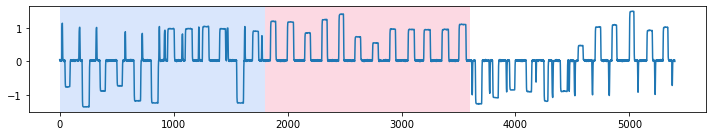

In [58]:
filepath = './datasets/UMD/UMD_TRAIN.arff'

df = load_dataset_to_dataframe(filepath)
print(df)
print(df.shape)

# Konwersja dataframe na ndarray
ndarray = df.values
ch = ndarray[:,-1]
ndarray = ndarray[:, :-1]
# Alternatywnie można użyć .to_numpy() w nowszych wersjach Pandas
# ndarray = df.to_numpy()

change_points = np.array([],dtype=int)
l_p = ch[0]
for i, p in enumerate(ch):
    if(p!=l_p):
        change_points = np.append(change_points,int(i*150))
    l_p = p

rpt.display(ndarray.flatten(), change_points)

result,eval =  predict_change_points(ndarray.flatten(),len(ndarray.flatten()),change_points)
rpt.display(ndarray.flatten(), change_points,result)
eval

5400
[1. 1. 1. ... 1. 1. 1.]
[4400 1609]


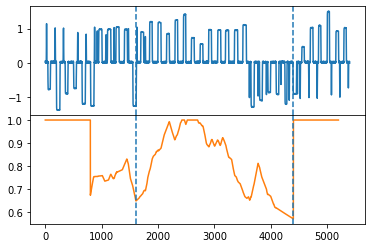

In [59]:
data = ndarray.flatten().transpose().astype(np.float64)

m = 200
mp = stumpy.stump(data, m=m)

L = 200
cac, regime_locations = stumpy.fluss(mp[:, 1], L=L, n_regimes=3, excl_factor=4)
print(len(data))

print(cac)
print(regime_locations)
fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0})
axs[0].plot(range(data.shape[0]), data)
axs[0].axvline(x=regime_locations[0], linestyle="dashed")
axs[1].plot(range(cac.shape[0]), cac, color='C1')
axs[1].axvline(x=regime_locations[0], linestyle="dashed")

axs[0].axvline(x=regime_locations[1], linestyle="dashed")
axs[1].axvline(x=regime_locations[1], linestyle="dashed")


plt.show()

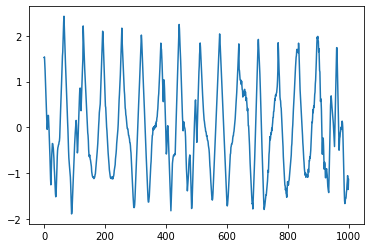

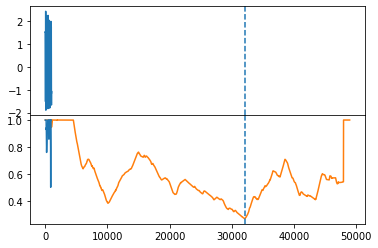

In [57]:
filepath = './datasets/SwedishLeaf/SwedishLeaf_TRAIN.arff'

df = load_dataset_to_dataframe(filepath)


# Konwersja dataframe na ndarray
ndarray = df.values
ch = ndarray[:,-1]
ndarray = ndarray[:, :-1]
# Alternatywnie można użyć .to_numpy() w nowszych wersjach Pandas
# ndarray = df.to_numpy()

change_points = np.array([],dtype=int)
l_p = ch[0]
for i, p in enumerate(ch):
    if(p!=l_p):
        change_points = np.append(change_points,int(i*128))
    l_p = p

#rpt.display(ndarray.flatten()[0:1590], change_points[:4])

data = ndarray.flatten().transpose().astype(np.float64)
data = data[:1000]
plt.plot(data)

m = 64
mp = stumpy.stump(data, m=m)

L = 64
# cac, regime_locations = stumpy.fluss(mp[:, 1], L=L, n_regimes=15, excl_factor=1)

# fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0})
# axs[0].plot(range(data.shape[0]), data)
# axs[0].axvline(x=regime_locations[0], linestyle="dashed")
# axs[1].plot(range(cac.shape[0]), cac, color='C1')
# axs[1].axvline(x=regime_locations[0], linestyle="dashed")

# axs[0].axvline(x=regime_locations[1], linestyle="dashed")
# axs[1].axvline(x=regime_locations[1], linestyle="dashed")


# plt.show()

cac_1d = _cac(mp[:, 3], L, bidirectional=False, excl_factor=1) 
fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0})
axs[0].plot(np.arange(data.shape[0]), data)
axs[0].axvline(x=regime_locations[0], linestyle="dashed")
axs[1].plot(range(cac.shape[0]), cac, color='C1')
axs[1].axvline(x=regime_locations[0], linestyle="dashed")
axs[1].plot(range(cac_1d.shape[0]), cac_1d)
plt.show()

# Experiment 4 (Cricket)

1197
(6,)
6


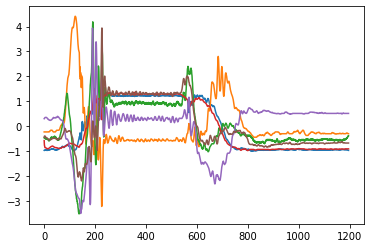

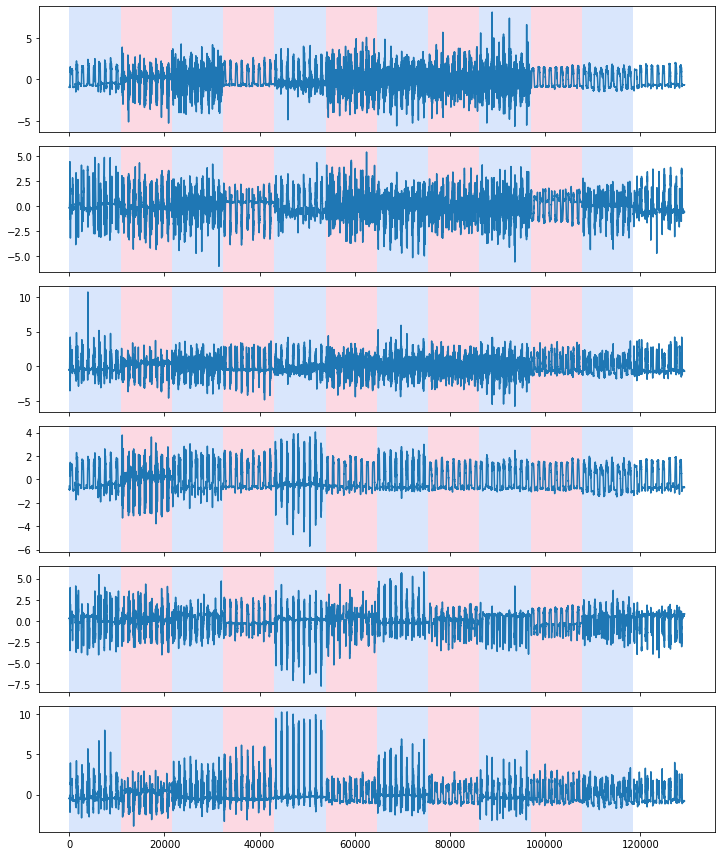

In [197]:
filepath = './datasets/Cricket/Cricket_TRAIN.arff'

df = load_dataset_to_dataframe(filepath)
print(len(df.iloc[0,0][0]))
window_size = len(df.iloc[0,0][0])

cricet_stacked, original_points = stack_time_series_randomly(df,False)
cricet_stacked_ndarray = dataframe_to_ndarray(cricet_stacked)
original_points = original_points.astype(dtype = int)

cricket_ds = cricet_stacked_ndarray.astype(np.float64)
plt.plot(cricket_ds[:window_size,:])
rpt.display(cricket_ds, original_points)

n = cricket_ds.shape[0]

# BottomUp in Cricket

C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


1469.0454545454545


,Metryka,Wartość
0,Acc,0.999835
1,Prec,0.272727
2,Recall,0.272727
3,F1,0.272727
4,ASC,0.272727
5,ASD,431.000000
6,ADT,0.333333


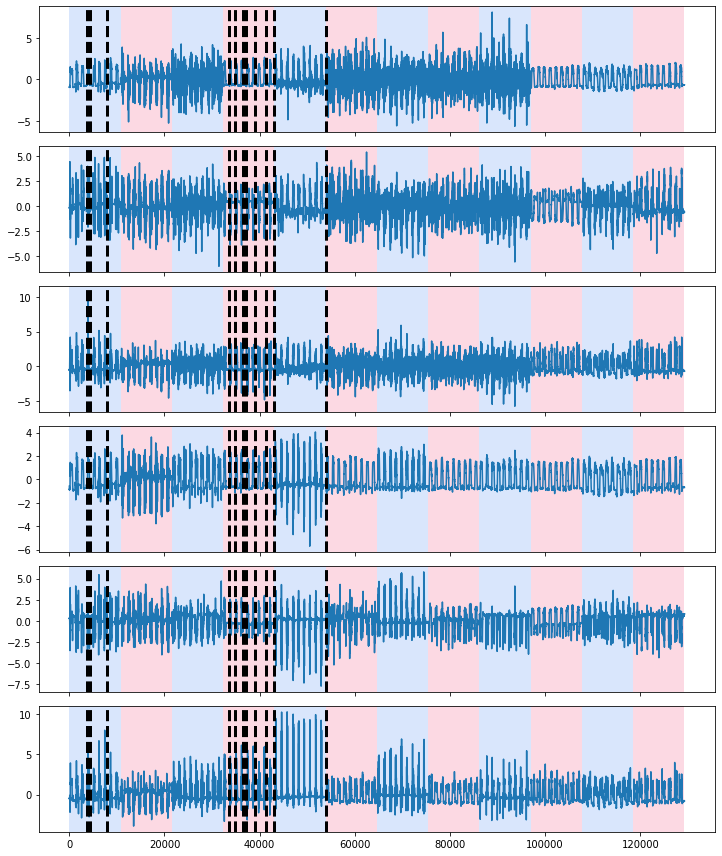

In [203]:
eval, result = predict_change_points_window(cricket_ds, n, original_points, "normal", window_size)
eval



C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


1469.0454545454545


,Metryka,Wartość
0,Acc,1.000000
1,Prec,1.000000
2,Recall,1.000000
3,F1,1.000000
4,ASC,1.000000
5,ASD,47.454545
6,ADT,0.636364


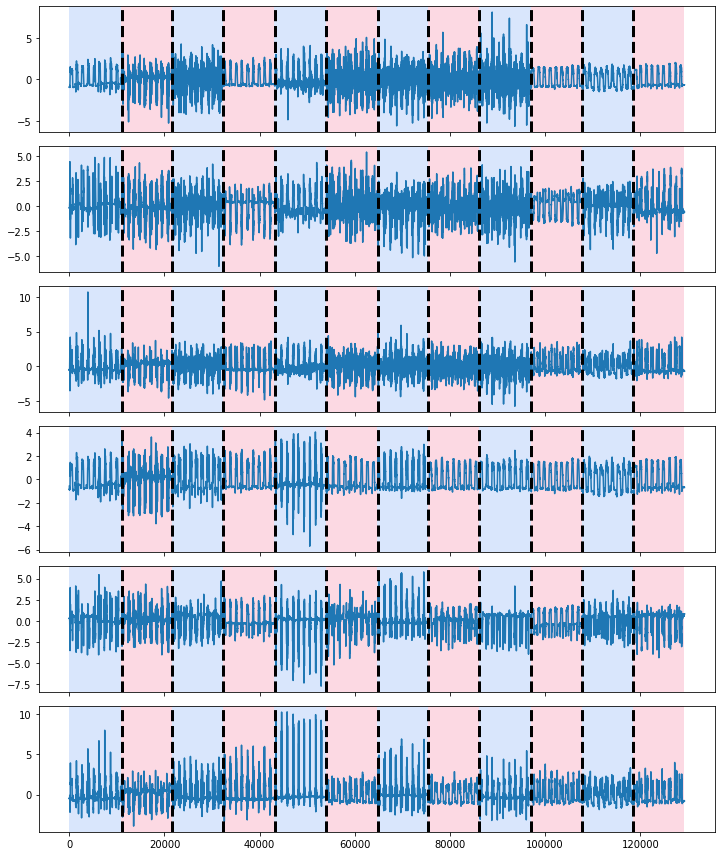

In [206]:
eval, result = predict_change_points_binseg(cricket_ds, n, original_points, "normal")
eval



C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


1469.0454545454545


,Metryka,Wartość
0,Acc,0.999938
1,Prec,0.727273
2,Recall,0.727273
3,F1,0.727273
4,ASC,0.727273
5,ASD,285.000000
6,ADT,0.375000


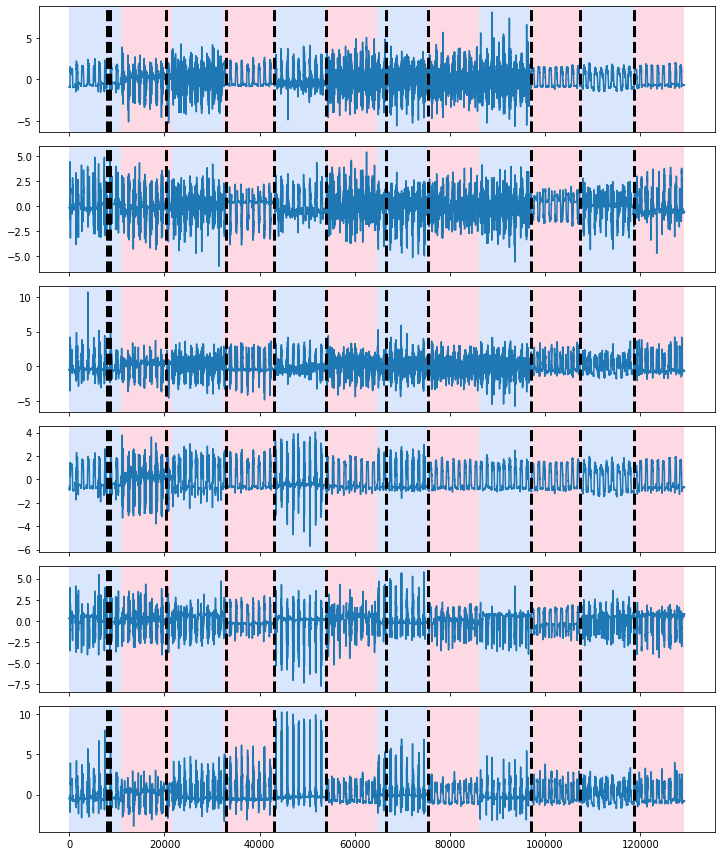

In [204]:
eval, result = predict_change_points_bottomup(cricket_ds, n, original_points, "normal")
eval



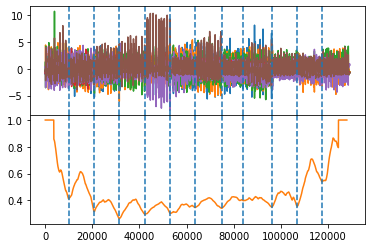

NameError: name 'get_fluss_evaluation' is not defined

In [195]:
FlussRegimeSegmentator = Fluss(window_size,3)

cac, regimes = FlussRegimeSegmentator.m_predict_regimes(cricket_ds)
FlussRegimeSegmentator.print_latest_output()



In [198]:
eval = get_evaluation(regimes,original_points,n)
eval

1469.0454545454545


,Metryka,Wartość
0,Acc,0.999979
1,Prec,0.909091
2,Recall,0.909091
3,F1,0.909091
4,ASC,0.909091
5,ASD,789.500000
6,ADT,0.000000


# Experiment 5 (SweadishLeafs 1)

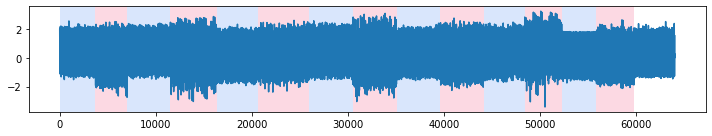

In [240]:
filepath = './datasets/SwedishLeaf/SwedishLeaf_TRAIN.arff'
def loadSweadishLeafsWithRegimes(filepath):
    df = load_dataset_to_dataframe(filepath)
    # mask = df['target'].values == b'4'
    # mask1 = df['target'].values == b'11'
    # ndarray = df.values[mask]
    # ndarray1 = df.values[mask1]
    # sw_leaf_data = np.concatenate((ndarray[:,:-1].flatten()[:1500], ndarray1[:,:-1].flatten()[:1500])).astype(dtype=float)
    original_points = np.array([])
    data = np.array([])
    groups = df.groupby('target')
    window_size = len(df.columns) - 1
    # Iteracja po grupach
    sum = 0 
    for name, group in groups:
        #print(f"Grupa: {name}")
        #print(group.shape[0])
        #print(group)
        data = np.concatenate((data, group.values[:,:-1].flatten())).astype(dtype=float)
        original_points = np.append(original_points, sum + group.shape[0]*( group.shape[1]-1))
        sum += group.shape[0]*( group.shape[1]-1)
    return data, original_points[:-1].astype(dtype = int), window_size
    

swleaf_data, original_points, window_size = loadSweadishLeafsWithRegimes(filepath)

rpt.display(swleaf_data, original_points)
n = swleaf_data.shape[0]

571.4285714285714


,Metryka,Wartość
0,Acc,0.999583
1,Prec,0.285714
2,Recall,0.285714
3,F1,0.285714
4,ASC,0.285714
5,ASD,305.500000
6,ADT,0.500000


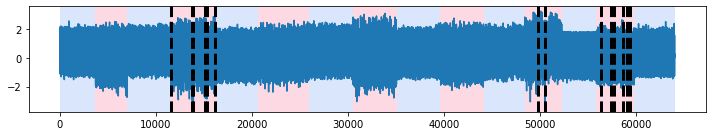

In [242]:
eval, result = predict_change_points_window(swleaf_data, n, original_points, "l2", window_size)
eval



C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


571.4285714285714


,Metryka,Wartość
0,Acc,0.999417
1,Prec,0.000000
2,Recall,0.000000
3,F1,0.000000
4,ASC,0.000000
5,ASD,-1.000000
6,ADT,-1.000000


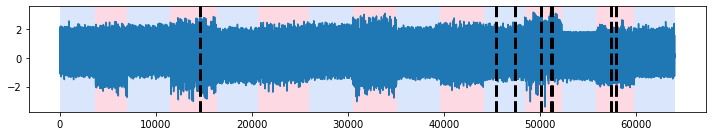

In [248]:
eval, result = predict_change_points_bottomup(swleaf_data, n, original_points, "normal")
eval



C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


571.4285714285714


,Metryka,Wartość
0,Acc,0.999417
1,Prec,0.000000
2,Recall,0.000000
3,F1,0.000000
4,ASC,0.000000
5,ASD,-1.000000
6,ADT,-1.000000


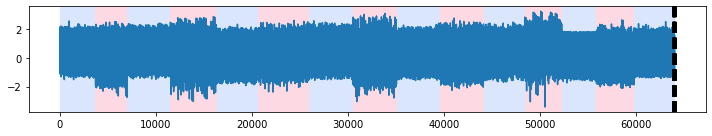

In [249]:
eval, result = predict_change_points_binseg(swleaf_data, n, original_points, "normal")
eval



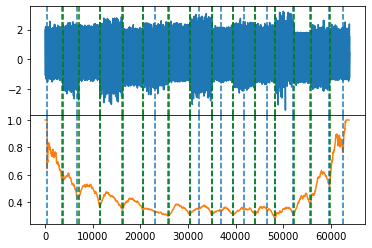

571.4285714285714


,Metryka,Wartość
0,Acc,0.999854
1,Prec,0.666667
2,Recall,1.000000
3,F1,0.800000
4,ASC,1.000000
5,ASD,103.857143
6,ADT,0.000000


In [237]:
FlussRegimeSegmentator = Fluss(window_size,3)

cac, regimes = FlussRegimeSegmentator.predict_regimes(swleaf_data)
FlussRegimeSegmentator.print_latest_output(original_points)

eval = get_evaluation(regimes, original_points, swleaf_data.shape[0])
eval

# BottomUp in SWLeafs

C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


14
571.4285714285714
[14605, 14640, 45390, 45415, 47380, 47405, 50060, 50095, 51145, 51190, 57320, 57365, 57835, 57880, 64000]
[14605, 14640, 45390, 45415, 47380, 47405, 50060, 50095, 51145, 51190, 57320, 57365, 57835, 57880, 64000]


,Metryka,Wartość
0,Score,0.414750
1,Acc,0.999417
2,Prec,0.000000
3,Recall,0.000000
4,F1,0.000000
5,ASC,0.000000
6,ASD,-1.000000
7,ADT,-1.000000


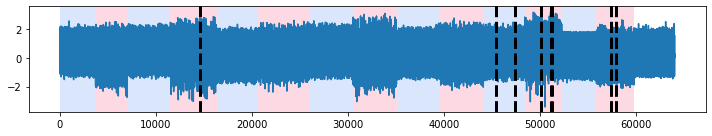

In [15]:

eval,result = predict_change_points(sw_leaf_data,len(sw_leaf_data),original_points,"normal")

rpt.display(sw_leaf_data,original_points,result)
print(result)
eval

